## Importy i konfiguracja

In [29]:
# --- podstawy ---
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# --- sklearn: przygotowanie, modele, metryki, pipeline ---
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# --- xgboost (boosting drzew) ---
import xgboost as xgb
import shap 
# --- wizualizacje ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,5)

DATA_PATH = Path("../data/processed/epl_features.csv")
RANDOM_STATE = 42


## Wczytanie danych, sortowanie i szybki podgląd

In [30]:
df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.sort_values(["Date", "HomeTeam", "AwayTeam"]).reset_index(drop=True)
print(df.shape)
df.head(3)


(3420, 100)


,Div,Date,HomeTeam,AwayTeam,Referee,FTHG,FTAG,FTR,HS,AS,...,IsHomeAlways1,Month,Weekday,IsWeekend,Home_AvgPts_season,Home_AvgGD_season,Away_AvgPts_season,Away_AvgGD_season,SeasonStrength_PtsDiff,SeasonStrength_GDDiff
0,E0,2014-08-16,Arsenal,Crystal Palace,J Moss,2.0,1.0,H,14.0,4.0,...,1,8,5,1,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2014-08-16,Leicester,Everton,M Jones,2.0,2.0,D,11.0,13.0,...,1,8,5,1,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2014-08-16,Manchester United,Swansea,M Dean,1.0,2.0,A,14.0,5.0,...,1,8,5,1,NaN,NaN,NaN,NaN,NaN,NaN


## Definicja targetu i wybór cech (X)

Poniżej automatycznie budujemy listę cech zgodnie z ustaleniami: bez kolumn „post-match” (gole/strzały bieżącego meczu) i bez identyfikatorów. Zostawiamy: rynkowe (prob/margin/spreads), formę (Home/Away/FormDiff/… w tym trend), cechy sezonowe oraz czasowe.

In [31]:
target = "FTR"

cols_to_exclude = {
    # meta / identyfikatory
    "Div", "Date", "Season", "SourceFile", "HomeTeam", "AwayTeam", "Referee",

    # wynik meczu – niedostępne przed spotkaniem
    "FTHG", "FTAG", "HTHG", "HTAG", "FTR",
    "GoalDiff", "TotalGoals",
    "HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC",
    "HY", "AY", "HR", "AR",

    # bukmacher – nadmiarowe prawdopodobieństwa i miary
    "Prob_D_b365", "Prob_A_b365",
    "Prob_H_ps", "Prob_D_ps", "Prob_A_ps",
    "Margin_B365", "Margin_PS",
    "OddsDiff_B365", "OddsDiff_PS",
    "OddsSpread_H", "OddsSpread_D", "OddsSpread_A",

    # forma gospodarzy – duplikaty lub mało stabilne
    "Home_Wins_last5",
    "Home_CleanSheets_last5",
    "Home_Conceded0plus_last5",
    "Home_GD_last3",
    "Home_Pts_last3",
    "Home_GD_last10",         # silna korelacja z Pts_last10
    "Home_AvgGD_season",

    # forma gości – duplikaty lub mało stabilne
    "Away_Wins_last5",
    "Away_CleanSheets_last5",
    "Away_Conceded0plus_last5",
    "Away_GD_last3",
    "Away_Pts_last3",
    "Away_GD_last10",         # silna korelacja z Pts_last10
    "Away_AvgGD_season",

    # FormDiff – różnice formy (duplikaty)
    "FormDiff_Wins_last5",
    "FormDiff_CleanSheets_last5",
    "FormDiff_Conceded0plus_last5",
    "FormDiff_GD_last3",
    "FormDiff_Pts_last3",
    "FormDiff_GD_last10",
    "FormDiff_Pts_last10",

    # kalendarz – duplikat Weekday
    "IsWeekend",

    # siła sezonu – duplikat PtsDiff
    "SeasonStrength_GDDiff",
}


# kandydaci na cechy:
candidate_cols = [
    c for c in df.columns
    if c not in cols_to_exclude
]

# wzorce cech predykcyjnych (rynek, forma, sezon, czas)
keep_patterns = (
    "Prob_", "Margin_", "OddsDiff", "OddsSpread",
    "Home_", "Away_", "FormDiff_", "Pts_trend_3v10",
    "SeasonStrength_", "Month", "Weekday", "IsWeekend"
)

X_features = [c for c in candidate_cols if any(p in c for p in keep_patterns)]

# sanity check
print(f"Liczba wybranych cech: {len(X_features)}")
X_features[:10]


Liczba wybranych cech: 23


['Prob_H_b365',
 'Home_GF_last5',
 'Home_GA_last5',
 'Home_GD_last5',
 'Home_Pts_last5',
 'Home_Pts_last10',
 'Home_Pts_trend_3v10',
 'Away_GF_last5',
 'Away_GA_last5',
 'Away_GD_last5']

## 3) Przygotowanie X, y i podział czasowy (train/test)

Używamy splitu po dacie, żeby unikać przecieku informacji między sezonami.

In [32]:
# label encoding dla y (H/D/A -> 0/1/2)
le = LabelEncoder()
y = le.fit_transform(df[target])

# split po dacie (przykład: uczymy na meczach przed 2020-01-01, testujemy na 2020+)
split_date = pd.Timestamp("2022-07-01")
train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X = df[X_features].copy()

X_train = X.loc[train_mask].reset_index(drop=True)
X_test  = X.loc[test_mask].reset_index(drop=True)
y_train = y[train_mask]
y_test  = y[test_mask]

X_train.shape, X_test.shape, len(y_train), len(y_test)


((2660, 23), (760, 23), 2660, 760)

## MODELE REGRESYJNE DO PREDYKCJI WYNIKÓW MECZÓW

Liczba cech: 23

=== CROSS-VALIDATION (RMSE) ===
Linear Regression: RMSE mean=0.9324 | std=0.3089
Ridge Regression: RMSE mean=0.7807 | std=0.0233
Lasso Regression: RMSE mean=0.7793 | std=0.0240
ElasticNet Regression: RMSE mean=0.7798 | std=0.0238

==================== Linear Regression ====================
RMSE: 0.7763
R²:   0.1962
Accuracy (po mapowaniu): 0.3658
Macro-F1 (po mapowaniu): 0.3320


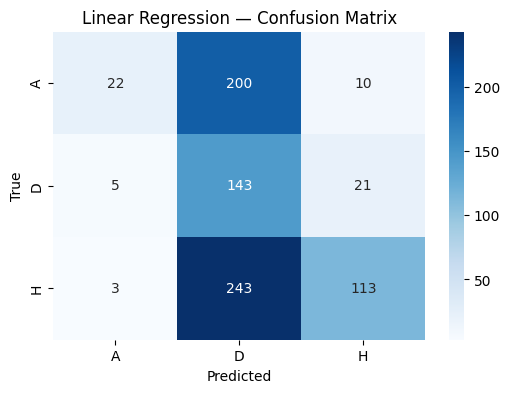


==================== Ridge Regression ====================
RMSE: 0.7764
R²:   0.1960
Accuracy (po mapowaniu): 0.3645
Macro-F1 (po mapowaniu): 0.3308


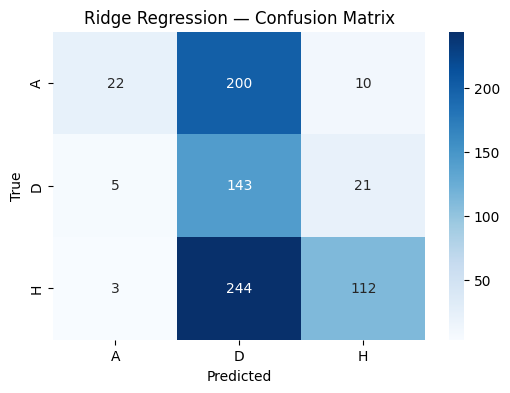


==================== Lasso Regression ====================
RMSE: 0.7762
R²:   0.1964
Accuracy (po mapowaniu): 0.3605
Macro-F1 (po mapowaniu): 0.3257


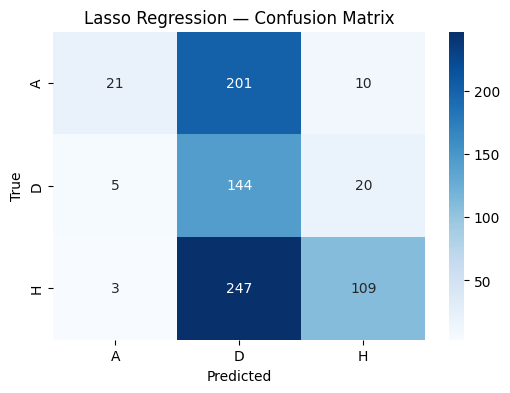


==================== ElasticNet Regression ====================
RMSE: 0.7763
R²:   0.1962
Accuracy (po mapowaniu): 0.3632
Macro-F1 (po mapowaniu): 0.3296


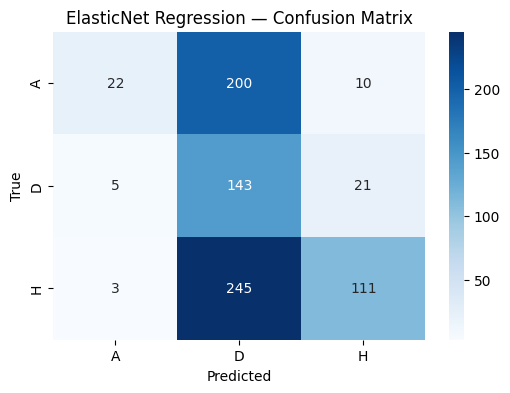


=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA A) ===


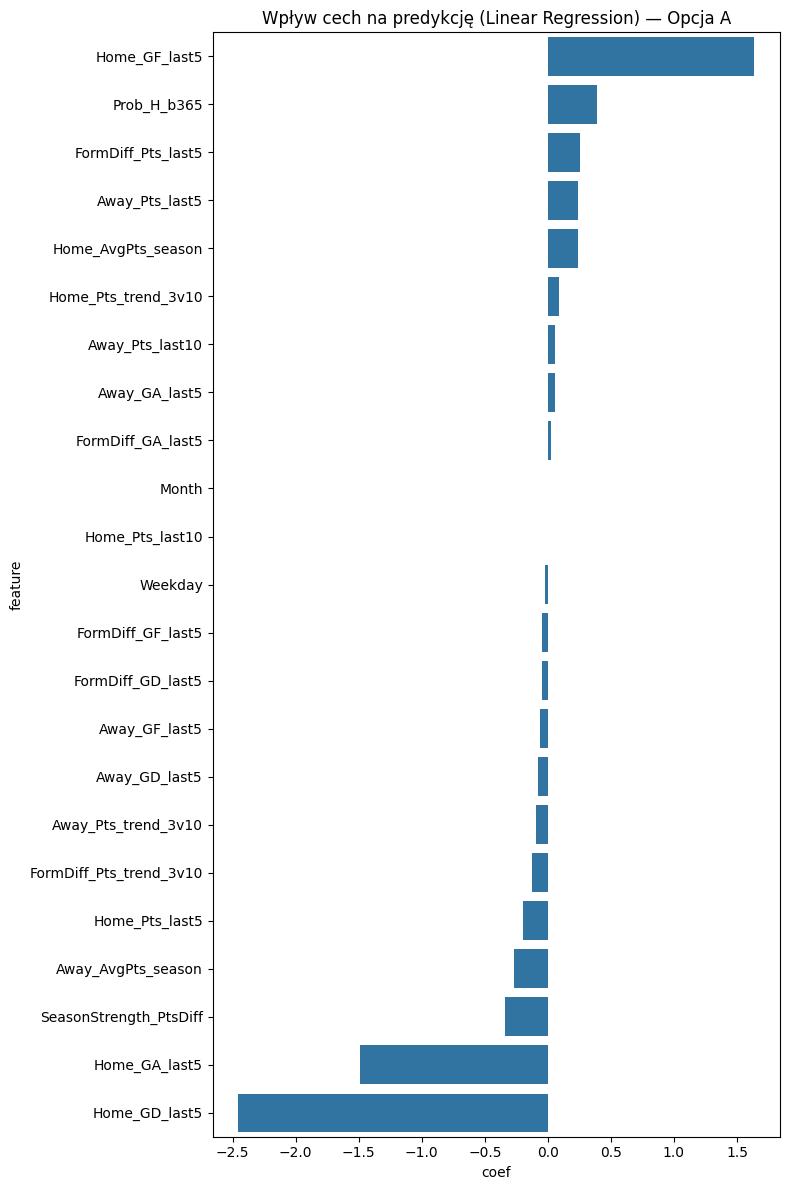

,feature,coef
1,Home_GF_last5,1.636827
0,Prob_H_b365,0.392940
16,FormDiff_Pts_last5,0.256905
10,Away_Pts_last5,0.240275
20,Home_AvgPts_season,0.239361
6,Home_Pts_trend_3v10,0.085393
11,Away_Pts_last10,0.058476
8,Away_GA_last5,0.056741
14,FormDiff_GA_last5,0.026770
18,Month,0.003766


In [33]:
# ============================================
# 1. Importy
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler





# ============================================
# 2. Selekcja cech
# ============================================

target = "FTR"

cols_to_exclude = {
    # meta / identyfikatory
    "Div", "Date", "Season", "SourceFile", "HomeTeam", "AwayTeam", "Referee",

    # wynik meczu – niedostępne przed spotkaniem
    "FTHG", "FTAG", "HTHG", "HTAG", "FTR",
    "GoalDiff", "TotalGoals",
    "HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC",
    "HY", "AY", "HR", "AR",

    # bukmacher – nadmiarowe prawdopodobieństwa i miary
    "Prob_D_b365", "Prob_A_b365",
    "Prob_H_ps", "Prob_D_ps", "Prob_A_ps",
    "Margin_B365", "Margin_PS",
    "OddsDiff_B365", "OddsDiff_PS",
    "OddsSpread_H", "OddsSpread_D", "OddsSpread_A",

    # forma gospodarzy – duplikaty lub mało stabilne
    "Home_Wins_last5",
    "Home_CleanSheets_last5",
    "Home_Conceded0plus_last5",
    "Home_GD_last3",
    "Home_Pts_last3",
    "Home_GD_last10",         # silna korelacja z Pts_last10
    "Home_AvgGD_season",

    # forma gości – duplikaty lub mało stabilne
    "Away_Wins_last5",
    "Away_CleanSheets_last5",
    "Away_Conceded0plus_last5",
    "Away_GD_last3",
    "Away_Pts_last3",
    "Away_GD_last10",         # silna korelacja z Pts_last10
    "Away_AvgGD_season",

    # FormDiff – różnice formy (duplikaty)
    "FormDiff_Wins_last5",
    "FormDiff_CleanSheets_last5",
    "FormDiff_Conceded0plus_last5",
    "FormDiff_GD_last3",
    "FormDiff_Pts_last3",
    "FormDiff_GD_last10",
    "FormDiff_Pts_last10",

    # kalendarz – duplikat Weekday
    "IsWeekend",

    # siła sezonu – duplikat PtsDiff
    "SeasonStrength_GDDiff",
}

candidate_cols = [c for c in df.columns if c not in cols_to_exclude]

keep_patterns = (
    "Prob_", "Margin_", "OddsDiff", "OddsSpread",
    "Home_", "Away_", "FormDiff_", "Pts_trend_3v10",
    "SeasonStrength_", "Month", "Weekday", "IsWeekend"
)

X_features = [c for c in candidate_cols if any(p in c for p in keep_patterns)]

print("Liczba cech:", len(X_features))



# ============================================
# 3. Kodowanie celu (OPCJA A)
# ============================================

encoding = {"A": -1, "D": 0, "H": 1}
y = df[target].map(encoding).values




# ============================================
# 4. Podział danych czasowy
# ============================================

split_date = pd.Timestamp("2022-07-01")

train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X = df[X_features].copy()

X_train = X.loc[train_mask].reset_index(drop=True)
X_test  = X.loc[test_mask].reset_index(drop=True)
y_train = y[train_mask]
y_test  = y[test_mask]

X_train.shape, X_test.shape




# ============================================
# 5. Funkcja: predykcja regresji → klasa
# ============================================

def regress_to_class(y_pred):
    # zwróci 0=A, 1=D, 2=H
    return np.digitize(y_pred, bins=[-0.5, 0.5])









# ============================================
# 6. Ewaluacja modelu regresyjnego
# ============================================

def evaluate_regression_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n==================== {name} ====================")

    # --- trenowanie ---
    model.fit(X_train, y_train)
    y_pred_cont = model.predict(X_test)

    # --- metryki regresyjne ---
    rmse = mean_squared_error(y_test, y_pred_cont, squared=False)
    r2 = r2_score(y_test, y_pred_cont)
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # --- mapowanie regresji -> klasy ---
    y_pred = regress_to_class(y_pred_cont)   # wyniki: 0, 1, 2

    # prawdziwe dane (-1, 0, 1) -> A,D,H
    mapping_true = {-1:"A", 0:"D", 1:"H"}
    y_test_cls = [mapping_true[v] for v in y_test]

    # predykcje (0,1,2) -> A,D,H
    mapping_pred = {0:"A", 1:"D", 2:"H"}
    y_pred_cls = [mapping_pred[v] for v in y_pred]

    # --- metryki klasyfikacyjne ---
    acc = accuracy_score(y_test_cls, y_pred_cls)
    f1m = f1_score(y_test_cls, y_pred_cls, average="macro")
    print(f"Accuracy (po mapowaniu): {acc:.4f}")
    print(f"Macro-F1 (po mapowaniu): {f1m:.4f}")

    # --- confusion matrix ---
    cm = confusion_matrix(y_test_cls, y_pred_cls)
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["A","D","H"], yticklabels=["A","D","H"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

    return acc, f1m, rmse, r2











# ============================================
# 7. Pipeline
# ============================================

def make_pipeline(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])








# ============================================
# 8. Modele regresyjne
# ============================================

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}












# ============================================
# 9. Cross-validation RMSE
# ============================================

print("\n=== CROSS-VALIDATION (RMSE) ===")

for name, model in models.items():
    pipe = make_pipeline(model)
    scores = cross_val_score(
        pipe, X_train, y_train, cv=5,
        scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-scores)

    print(f"{name}: RMSE mean={rmse_scores.mean():.4f} | std={rmse_scores.std():.4f}")







# ============================================
# 10. Pełna ewaluacja modeli
# ============================================

results = []

for name, model in models.items():
    pipe = make_pipeline(model)
    acc, f1m, rmse, r2 = evaluate_regression_model(
        name, pipe, X_train, y_train, X_test, y_test
    )
    results.append([name, acc, f1m, rmse, r2])









# ============================================
# 11. Podsumowanie wyników
# ============================================

df_results = pd.DataFrame(
    results,
    columns=["Model","Accuracy","Macro-F1","RMSE","R²"]
)

print("\n=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA A) ===")
df_results








# ============================================
# 12. Analiza współczynników (Linear Regression)
# ============================================

lin_pipe = make_pipeline(LinearRegression())
lin_pipe.fit(X_train, y_train)

coefs = lin_pipe.named_steps["model"].coef_
features = X_train.columns

coef_df = pd.DataFrame({"feature": features, "coef": coefs})
coef_df = coef_df.sort_values("coef", ascending=False)

plt.figure(figsize=(8,12))
sns.barplot(data=coef_df, x="coef", y="feature")
plt.title("Wpływ cech na predykcję (Linear Regression) — Opcja A")
plt.tight_layout()
plt.show()

coef_df












<Axes: >

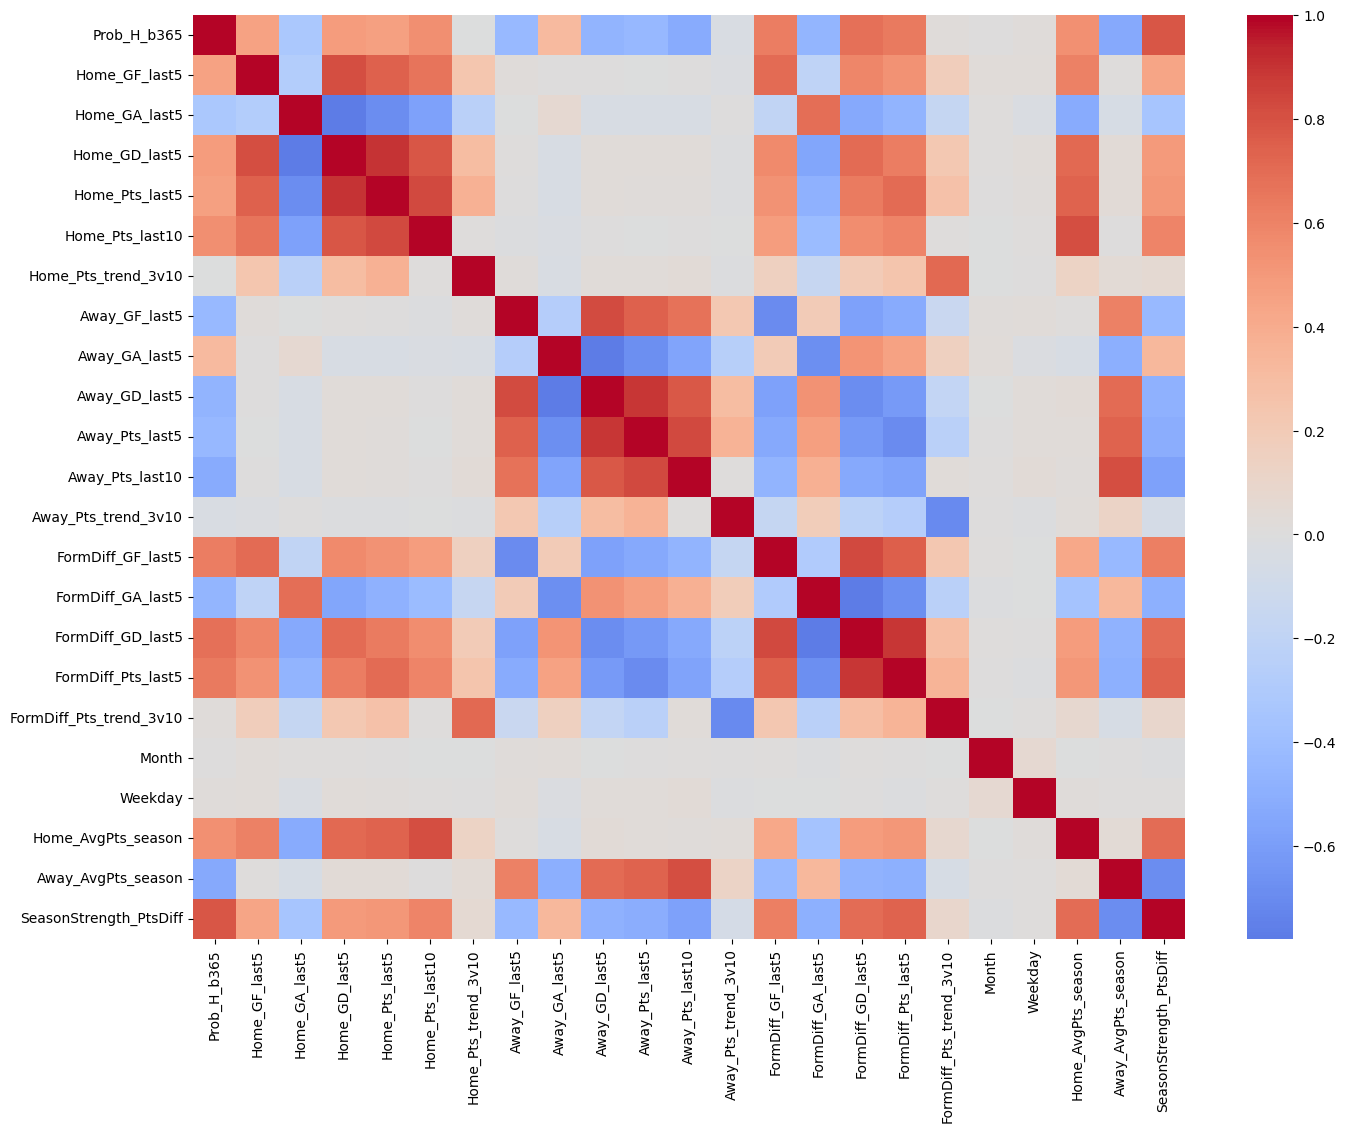

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[X_features].corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", center=0)


In [35]:
import pandas as pd
import numpy as np

# policz korelacje
corr = df[X_features].corr().abs()

# ustawienie wartości diagonalnych (1.0) na 0, żeby nie zaśmiecało wyników
np.fill_diagonal(corr.values, 0)

# znajdź pary z korelacją > 0.90
high_corr_pairs = [
    (col1, col2, corr.loc[col1, col2])
    for col1 in corr.columns
    for col2 in corr.columns
    if col1 < col2 and corr.loc[col1, col2] > 0.90
]

# wydruk
for p in high_corr_pairs:
    print(p)


In [36]:
high_corr = corr > 0.90
high_corr_sum = high_corr.sum().sort_values(ascending=False)

print(high_corr_sum)


Prob_H_b365                0
Away_Pts_trend_3v10        0
Away_AvgPts_season         0
Home_AvgPts_season         0
Weekday                    0
Month                      0
FormDiff_Pts_trend_3v10    0
FormDiff_Pts_last5         0
FormDiff_GD_last5          0
FormDiff_GA_last5          0
FormDiff_GF_last5          0
Away_Pts_last10            0
Home_GF_last5              0
Away_Pts_last5             0
Away_GD_last5              0
Away_GA_last5              0
Away_GF_last5              0
Home_Pts_trend_3v10        0
Home_Pts_last10            0
Home_Pts_last5             0
Home_GD_last5              0
Home_GA_last5              0
SeasonStrength_PtsDiff     0
dtype: int64


In [37]:
to_remove = set()

for c in corr.columns:
    if c not in to_remove:
        high_corr_cols = corr.index[corr[c] > 0.90].tolist()
        to_remove.update(high_corr_cols)

print("Cechy do usunięcia:", to_remove)


Cechy do usunięcia: set()


## OPCJA B

## 4.2. Model OPCJA B — Regresja GoalDiff i mapowanie na klasy H/D/A

W klasycznym podejściu (OPCJA A) model próbuje bezpośrednio przewidywać
kategorię wyniku meczu (H – wygrana gospodarzy, D – remis, A – wygrana gości).
Jest to jednak zadanie trudne dla modeli liniowych, ponieważ klasy są
dyskretne i nieliniowo separowalne.

Aby uzyskać bardziej stabilne wyniki, wprowadzono alternatywne podejście:

**OPCJA B — przewidywanie różnicy bramek (GoalDiff) jako zmiennej ciągłej,  
a następnie mapowanie wartości regresji na klasy H/D/A.**

Różnica bramek definiowana jest jako:

\[
GoalDiff = FTHG - FTAG
\]

gdzie:  
- *FTHG* – liczba bramek gospodarzy,  
- *FTAG* – liczba bramek gości.

Model regresyjny przewiduje wartość ciągłą `GoalDiff`, a następnie jest ona
mapowana na klasy:

- `A` – jeśli przewidywany GoalDiff < –0.5  
- `D` – jeśli –0.5 ≤ GoalDiff ≤ +0.5  
- `H` – jeśli GoalDiff > +0.5  

Takie podejście lepiej wykorzystuje właściwości modeli liniowych,
ponieważ różnica bramek jest zmienną ciągłą, a nie kategorią.  
W efekcie modele uczą się uporządkowanej struktury wyniku zamiast próbować
bezpośrednio zgadywać jedną z trzech nieuporządkowanych klas.

Poniżej przedstawiono pełną implementację modelu OPCJA B,
wraz z pipeline’em, metrykami regresyjnymi (RMSE, R²),
konwersją predykcji na klasy oraz miarami klasyfikacyjnymi
(Accuracy, Macro-F1) i macierzą pomyłek.




###########################################
##########        OPCJA B         #########
##########   REGRESJA GOALDIFF    #########
###########################################


=== CROSS-VALIDATION (RMSE) — OPCJA B ===
Linear Regression: RMSE mean=2.0179 | std=0.8093
Ridge Regression: RMSE mean=1.6319 | std=0.0622
Lasso Regression: RMSE mean=1.6302 | std=0.0627
ElasticNet Regression: RMSE mean=1.6309 | std=0.0627

==================== Linear Regression (OPCJA B) ====================
RMSE: 1.7517
R²:   0.2192
Accuracy: 0.5211
Macro-F1: 0.5001


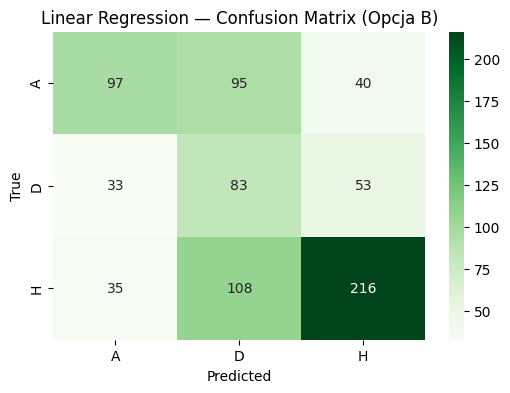


==================== Ridge Regression (OPCJA B) ====================
RMSE: 1.7514
R²:   0.2195
Accuracy: 0.5197
Macro-F1: 0.4985


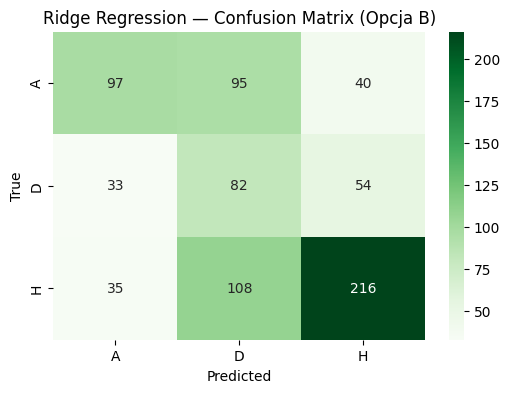


==================== Lasso Regression (OPCJA B) ====================
RMSE: 1.7510
R²:   0.2198
Accuracy: 0.5184
Macro-F1: 0.4988


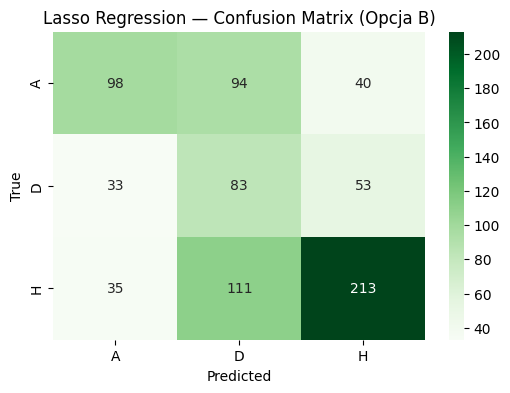


==================== ElasticNet Regression (OPCJA B) ====================
RMSE: 1.7510
R²:   0.2198
Accuracy: 0.5211
Macro-F1: 0.5007


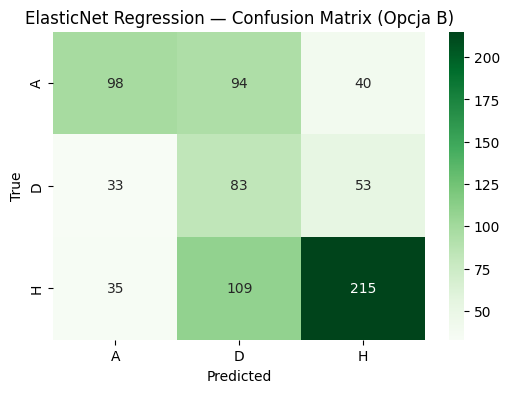


=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA B) ===


,Model,Accuracy,Macro-F1,RMSE,R²
0,Linear Regression,0.521053,0.500069,1.751699,0.219235
1,Ridge Regression,0.519737,0.498546,1.751442,0.219464
2,Lasso Regression,0.518421,0.498767,1.751021,0.219840
3,ElasticNet Regression,0.521053,0.500658,1.751014,0.219845


In [38]:
# =========================================================
# OPCJA B — REGRESJA NA GOALDIFF + MAPOWANIE NA KLASY H/D/A
# =========================================================

print("\n\n###########################################")
print("##########        OPCJA B         #########")
print("##########   REGRESJA GOALDIFF    #########")
print("###########################################\n")


# ============================================
# 1. Tworzymy target: GoalDiff = FTHG - FTAG
# ============================================

df["GoalDiff_reg"] = df["FTHG"] - df["FTAG"]     # ◀ TARGET OPCJI B

yB = df["GoalDiff_reg"].values


# ============================================
# 2. Podział czasowy taki sam jak w Opcji A
# ============================================

X_train_B = X.loc[train_mask].reset_index(drop=True)
X_test_B  = X.loc[test_mask].reset_index(drop=True)
y_train_B = yB[train_mask]
y_test_B  = yB[test_mask]


# ============================================
# 3. Regresja → Klasa (H/D/A)
# ============================================

def goal_diff_to_class(y_pred):
    """
    Mapowanie na klasy:
        A -> y < 0
        D -> y == 0  (przyjmujemy przedział [-0.5, +0.5])
        H -> y > 0
    """
    classes = []
    for v in y_pred:
        if v < -0.5:
            classes.append("A")
        elif v > 0.5:
            classes.append("H")
        else:
            classes.append("D")
    return classes



# ============================================
# 4. Ewaluacja modelu OPCJI B
# ============================================

def evaluate_opcjaB(name, model, X_train, y_train, X_test, y_test):
    print(f"\n==================== {name} (OPCJA B) ====================")

    # --- trening ---
    model.fit(X_train, y_train)
    y_pred_cont = model.predict(X_test)

    # --- metryki regresyjne ---
    rmse = mean_squared_error(y_test, y_pred_cont, squared=False)
    r2   = r2_score(y_test, y_pred_cont)
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # --- mapowanie GoalDiff → klasa ---
    y_pred_cls = goal_diff_to_class(y_pred_cont)

    # --- prawdziwe klasy ---
    y_test_cls = []
    for v in y_test:
        if v < 0:
            y_test_cls.append("A")
        elif v > 0:
            y_test_cls.append("H")
        else:
            y_test_cls.append("D")

    # --- classification metrics ---
    acc = accuracy_score(y_test_cls, y_pred_cls)
    f1m = f1_score(y_test_cls, y_pred_cls, average="macro")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-F1: {f1m:.4f}")

    # --- confusion matrix ---
    cm = confusion_matrix(y_test_cls, y_pred_cls, labels=["A","D","H"])
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Greens",
        xticklabels=["A","D","H"], yticklabels=["A","D","H"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} — Confusion Matrix (Opcja B)")
    plt.show()

    return acc, f1m, rmse, r2



# ============================================
# 5. Pipeline taki sam jak wcześniej
# ============================================

def make_pipeline_B(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])



# ============================================
# 6. Modele jak w Opcji A
# ============================================

models_B = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}



# ============================================
# 7. Cross-validation RMSE (Opcja B)
# ============================================

print("\n=== CROSS-VALIDATION (RMSE) — OPCJA B ===")

for name, model in models_B.items():
    pipeB = make_pipeline_B(model)
    scores = cross_val_score(
        pipeB, X_train_B, y_train_B, cv=5,
        scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-scores)
    print(f"{name}: RMSE mean={rmse_scores.mean():.4f} | std={rmse_scores.std():.4f}")



# ============================================
# 8. Pełna ewaluacja (Opcja B)
# ============================================

results_B = []

for name, model in models_B.items():
    pipeB = make_pipeline_B(model)
    acc, f1m, rmse, r2 = evaluate_opcjaB(
        name, pipeB, X_train_B, y_train_B, X_test_B, y_test_B
    )
    results_B.append([name, acc, f1m, rmse, r2])



# ============================================
# 9. Tabela wyników Opcji B
# ============================================

df_results_B = pd.DataFrame(
    results_B,
    columns=["Model","Accuracy","Macro-F1","RMSE","R²"]
)

print("\n=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA B) ===")
df_results_B




############################################
##########       OPCJA BINARNA      ########
##########      H vs (D + A)        ########
############################################


=== CROSS-VALIDATION (RMSE) — OPCJA BINARNA ===
Linear Regression: RMSE mean=0.4818 | std=0.0507
Ridge Regression: RMSE mean=0.4561 | std=0.0095
Lasso Regression: RMSE mean=0.4555 | std=0.0097
ElasticNet Regression: RMSE mean=0.4557 | std=0.0098

==================== Linear Regression (BINARY) ====================
RMSE: 0.4571
R²:   0.1616
Accuracy: 0.6789
Macro-F1: 0.6728


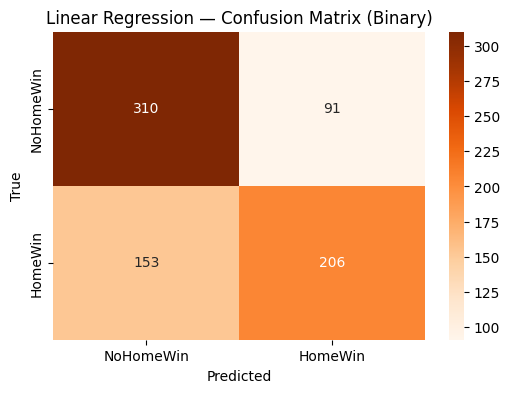


==================== Ridge Regression (BINARY) ====================
RMSE: 0.4572
R²:   0.1613
Accuracy: 0.6776
Macro-F1: 0.6714


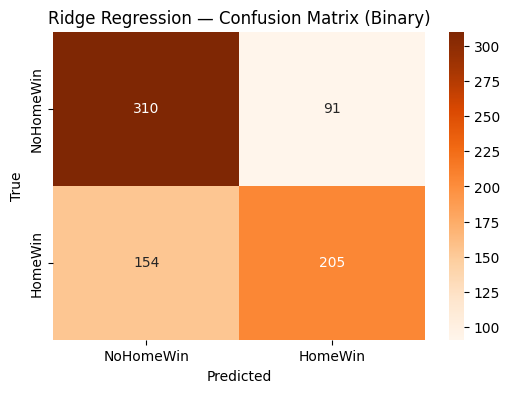


==================== Lasso Regression (BINARY) ====================
RMSE: 0.4567
R²:   0.1630
Accuracy: 0.6750
Macro-F1: 0.6677


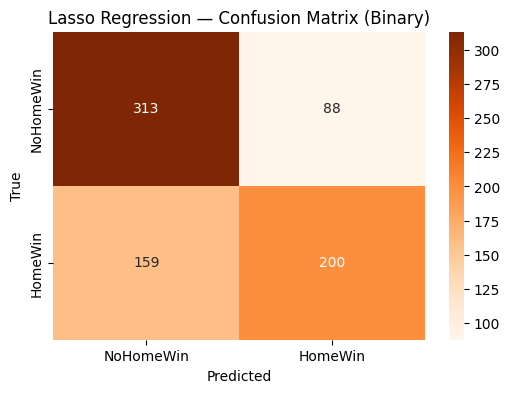


==================== ElasticNet Regression (BINARY) ====================
RMSE: 0.4569
R²:   0.1624
Accuracy: 0.6763
Macro-F1: 0.6694


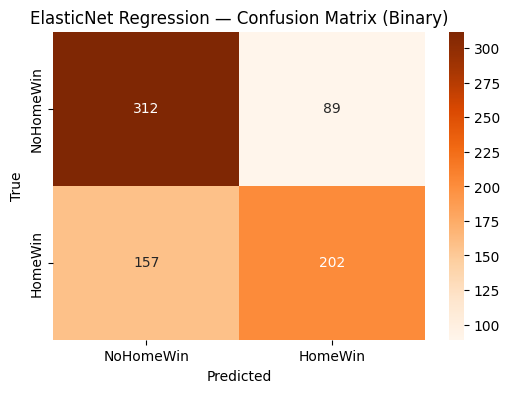


=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA BINARNA) ===


,Model,Accuracy,Macro-F1,RMSE,R²
0,Linear Regression,0.678947,0.672821,0.457119,0.161607
1,Ridge Regression,0.677632,0.671359,0.457194,0.161334
2,Lasso Regression,0.675000,0.667653,0.456745,0.162981
3,ElasticNet Regression,0.676316,0.669390,0.456908,0.162382


In [39]:
# ============================================================
# OPCJA BINARNA – H vs (D+A)
# Zwycięstwo gospodarzy (1) vs Brak zwycięstwa gospodarzy (0)
# ============================================================

print("\n\n############################################")
print("##########       OPCJA BINARNA      ########")
print("##########      H vs (D + A)        ########")
print("############################################\n")


# ============================================================
# 1. Kodowanie celu do postaci binarnej
# ============================================================

# FTR: H, D, A → 1, 0, 0
df["FTR_binary"] = df["FTR"].map({"H":1, "D":0, "A":0})

y_bin = df["FTR_binary"].values


# ============================================================
# 2. Podział czasowy taki sam jak w A i B
# ============================================================

X_train_bin = X.loc[train_mask].reset_index(drop=True)
X_test_bin  = X.loc[test_mask].reset_index(drop=True)
y_train_bin = y_bin[train_mask]
y_test_bin  = y_bin[test_mask]


# ============================================================
# 3. Funkcja ewaluacji modeli binarnych
# ============================================================

def evaluate_binary_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n==================== {name} (BINARY) ====================")

    # --- trening ---
    model.fit(X_train, y_train)
    y_pred_cont = model.predict(X_test)

    # --- regresja → klasy 0/1 ---
    # próg 0.5 (klasyczna decyzja binarna)
    y_pred_cls = (y_pred_cont >= 0.5).astype(int)

    # --- metryki ---
    acc = accuracy_score(y_test, y_pred_cls)
    f1m = f1_score(y_test, y_pred_cls, average="macro")
    rmse = mean_squared_error(y_test, y_pred_cont, squared=False)
    r2   = r2_score(y_test, y_pred_cont)

    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-F1: {f1m:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_cls)
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Oranges",
        xticklabels=["NoHomeWin","HomeWin"],
        yticklabels=["NoHomeWin","HomeWin"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} — Confusion Matrix (Binary)")
    plt.show()

    return acc, f1m, rmse, r2


# ============================================================
# 4. Pipeline (taki sam jak wcześniej)
# ============================================================

def make_pipeline_bin(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])


# ============================================================
# 5. Modele regresyjne
# ============================================================

models_bin = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}


# ============================================================
# 6. Cross-validation RMSE
# ============================================================

print("\n=== CROSS-VALIDATION (RMSE) — OPCJA BINARNA ===")

for name, model in models_bin.items():
    pipeB = make_pipeline_bin(model)
    scores = cross_val_score(
        pipeB, X_train_bin, y_train_bin, cv=5,
        scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-scores)
    print(f"{name}: RMSE mean={rmse_scores.mean():.4f} | std={rmse_scores.std():.4f}")


# ============================================================
# 7. Pełna ewaluacja
# ============================================================

results_bin = []

for name, model in models_bin.items():
    pipe = make_pipeline_bin(model)
    acc, f1m, rmse, r2 = evaluate_binary_model(
        name, pipe, X_train_bin, y_train_bin, X_test_bin, y_test_bin
    )
    results_bin.append([name, acc, f1m, rmse, r2])


# ============================================================
# 8. Finalna tabela wyników
# ============================================================

df_results_bin = pd.DataFrame(
    results_bin,
    columns=["Model","Accuracy","Macro-F1","RMSE","R²"]
)

print("\n=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA BINARNA) ===")
df_results_bin
